## $\kappa$-velo on pancreas

This notebook focuses on the application of $\kappa$-velo on the pancreas endocrinogenesis dataset. This dataset was originally published by Bastidas-Ponce and colleagues (https://doi.org/10.1242/dev.173849) and it is one of the datasets described in the original scVelo paper. 

In [1]:
### load libraries

# standard libraries
import numpy as np

# single-cell libraries
import anndata as ad
import scanpy as sc
import scvelo as scv
scv.settings.set_figure_params('scvelo', dpi_save=200, dpi=80, transparent=True)
scv.settings.verbosity = 0

# plotting libraries
import matplotlib.pyplot as plt

# dimension reductions
from sklearn.metrics import pairwise_distances #for creating tSNEs
from sklearn.manifold import TSNE #for creating tSNEs 
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap # for creating UMAPs

# other
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for transforming matrix from sparse to dense 
from scipy.spatial import cKDTree #used for Nystrom method
import time #to measure the time it takes to run script

# load our own 
from functions import *
from projection import *

In [2]:
### set scvelo settings
scv.settings.set_figure_params('scvelo', dpi_save=300, dpi=100, transparent=True)
scv.settings.verbosity = 0

In [3]:
### current timestamp
begin_time = time.time()

### Load original dataset

Here, we load the pancreas endocrinogenesis dataset. The dataset is made accesible in the scVelo package (version 0.2.4) where you can download it using the function `scvelo.datasets.pancreas()`. 

In [4]:
### load pancreas dataset
pancreas_path = "../datasets/pancreas/pancreas.h5ad"
adata = ad.read_h5ad(pancreas_path)

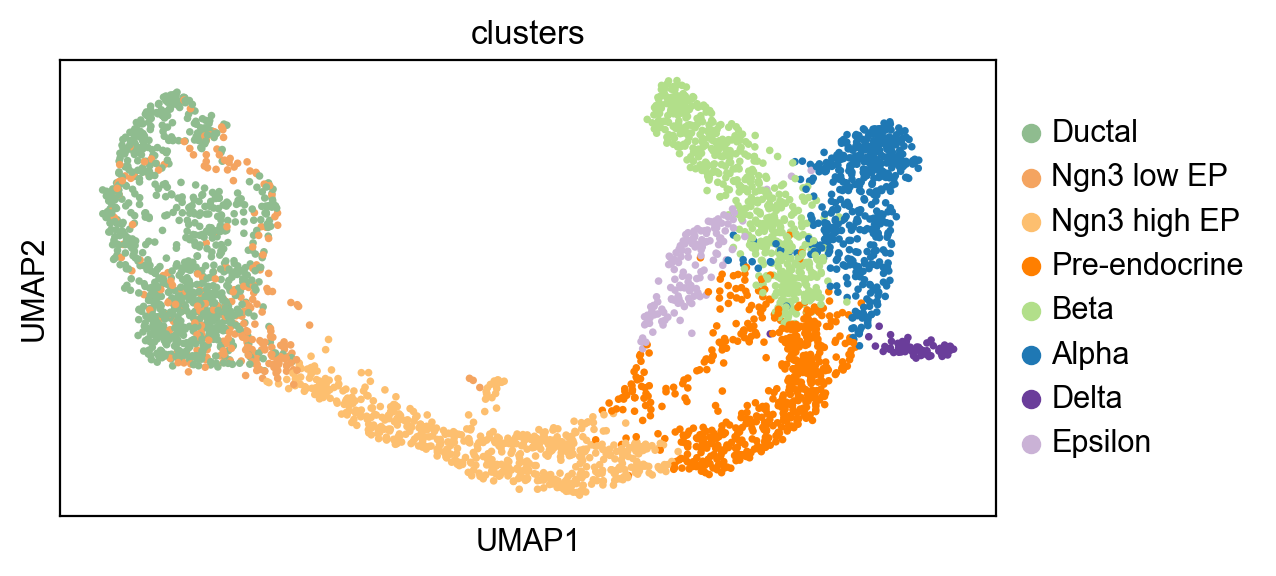

In [5]:
### plot dataset
fig, axs = plt.subplots(1, 1, figsize=(6, 3), frameon=False)
sc.pl.umap(adata, color="clusters", size=30, ax=axs)

### Processing of dataset

Here, we process the dataset. We deviate from the standard scVelo processing pipeline. The $\kappa$-velo processing workflow includes the following steps:

1. select highly variable genes (HVGs)
2. select genes with sufficient unspliced and spliced counts 
3. (L1) normalise U and S counts together
4. Impute counts (using scVelo)

If you want to know more about why certain steps of steps of processing are omitted or included, you can read all about it in our manuscript. 

First, we select 5000 HVGs on the spliced data, using analytic Pearson residuals (Lause et al., 2021 https://doi.org/10.1186/s13059-021-02451-7).

In [6]:
### select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=5000, theta=100)

In [7]:
### make subset with HVGs only
adata = adata[:, hvgs]

Next, we keep only genes with sufficient unspliced and spliced counts (maximum count should be above 3).

In [8]:
### subset for genes that have high enough U and S counts
minlim = 3
spliced_matrix = adata.layers['spliced'].todense()
unspliced_matrix = adata.layers['unspliced'].todense()
us_genes = (np.array(np.max(spliced_matrix, axis=0)).flatten() > minlim) & (np.array(np.max(unspliced_matrix, axis=0)).flatten() > minlim)
us_genes = adata.var_names[us_genes]
len(us_genes)

716

In [9]:
adata = adata[:,us_genes]

Then, we normalise the spliced and unspliced counts together using our function `L1_normalise`. 

In [10]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

In [11]:
### L1 normalise unspliced and spliced together
adata = L1_normalise(adata)

Last in the processing pipeline, we impute the spliced and unspliced. Since we removed genes from the original dataset, we will recalculate the PCA dimensions. 

In [12]:
### scale data
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["spliced"])

### run PCA
n_pcs = 15
pca = PCA(n_components=n_pcs)
pca.fit(spliced_scaled)
pca_embedding = pca.transform(spliced_scaled)

### delete original PCA and UMAP
del adata.obsm['X_pca']
del adata.obsm['X_umap']

### add PCA to adata object
adata.obsm['X_pca'] = pca_embedding

### calculate moments
scv.pp.moments(adata, n_pcs=n_pcs, n_neighbors=30)

### Calculate velocities
After processing, it is time to calculate the velocities for each cell. The $\kappa$-workflow contains 4 steps to calculate the velocities:

1. gene-wise inference of $\alpha$, $\beta$ and $\gamma$
2. remove low-likelihood genes
3. calculate scaling factor $\kappa$ per gene
4. calculate high-dimensional velocities per cell

First, we start with the gene-wise inferenceof the parameters using function `scvelo.tl.recover_dynamics`. 

In [13]:
### recover dynamics for all genes
scv.tl.recover_dynamics(adata, n_jobs=8, t_max=100, fit_connected_states=True, max_iter=100)

Next, we remove all genes for which the fitted likelihood is below 0.4. 

In [15]:
adata = ad.read_h5ad("pancreas_L1_preproc_fitted")

In [14]:
### get all genes sorted by likelihood
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)

### remove genes with no recovered dynamics
likelihood_genes = likelihood_genes.dropna()

### select genes with likelihood higher than x
likelihood_genes = likelihood_genes[likelihood_genes > 0.4]

### select only the genes in pandas series
likelihood_genes = likelihood_genes.index.values

len(likelihood_genes)

115

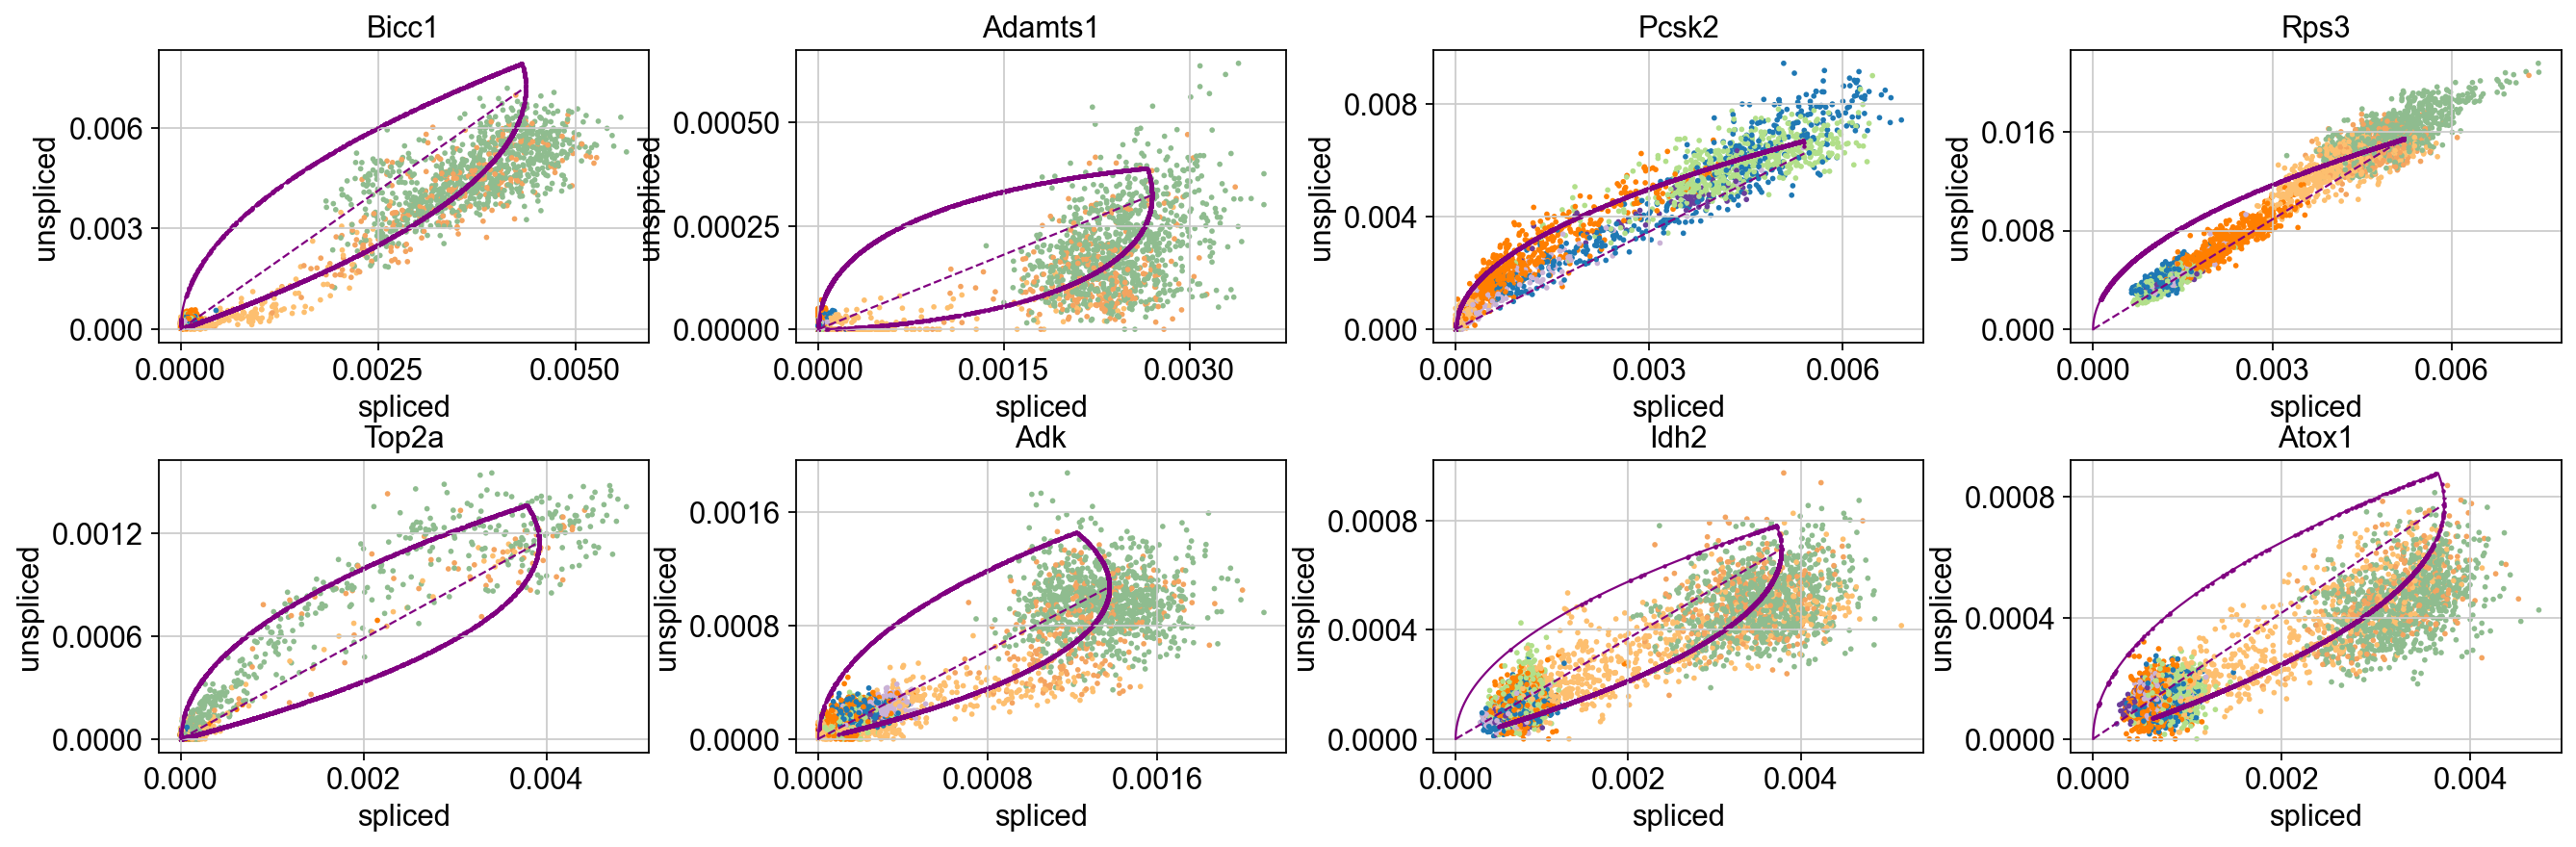

In [15]:
### plot top likelihood genes
sc.set_figure_params(figsize = (5,3))
scv.pl.scatter(adata, likelihood_genes[0:8], ncols=4, hspace=0.4, wspace=0.3)

In [17]:
### subset adata for genes with recovered parameters
adata = adata[:, likelihood_genes]

Then, we use the $\kappa$-velo function `get_intervals` to fit a kappa to each gene using all cells assigned to downregulation (for that gene). In case a NaN is retrieved (because there are not enough cells in downregulation), we run the function `get_intervals` again, but this time on all cells in the upregulation. 

In [20]:
### get kappas
fitted_kappas = np.array([np.nanmean(get_intervals(adata, i, mode="u", reg="down", use_raw=True)) for i in adata.var_names])
fitted_kappas[np.isnan(fitted_kappas)]=np.array([get_intervals(adata, i, mode="u", reg="up", use_raw=True)[0] for i in np.where(np.isnan(fitted_kappas))[0]])

Here, we scale the parameters $\alpha$, $\beta$ and $\gamma$ using the calculated scaling factors $\kappa$. The scale of recovered $\kappa$ will not be exactly true to time, but can be off by a constant factor related to the chosen $\Delta t$. However, if all components are scaled by the same factor, the direction of the high dimensional vector is still correct.

In [21]:
### scale parameters
new_alpha = adata.var["fit_alpha"]*fitted_kappas
new_beta = adata.var["fit_beta"]*fitted_kappas
new_gamma = adata.var["fit_gamma"]*fitted_kappas

Here, we make a figure to compare the originally fitted parameters to the scaled parameters. This figure is equivalent to Figure 4A in our main paper.

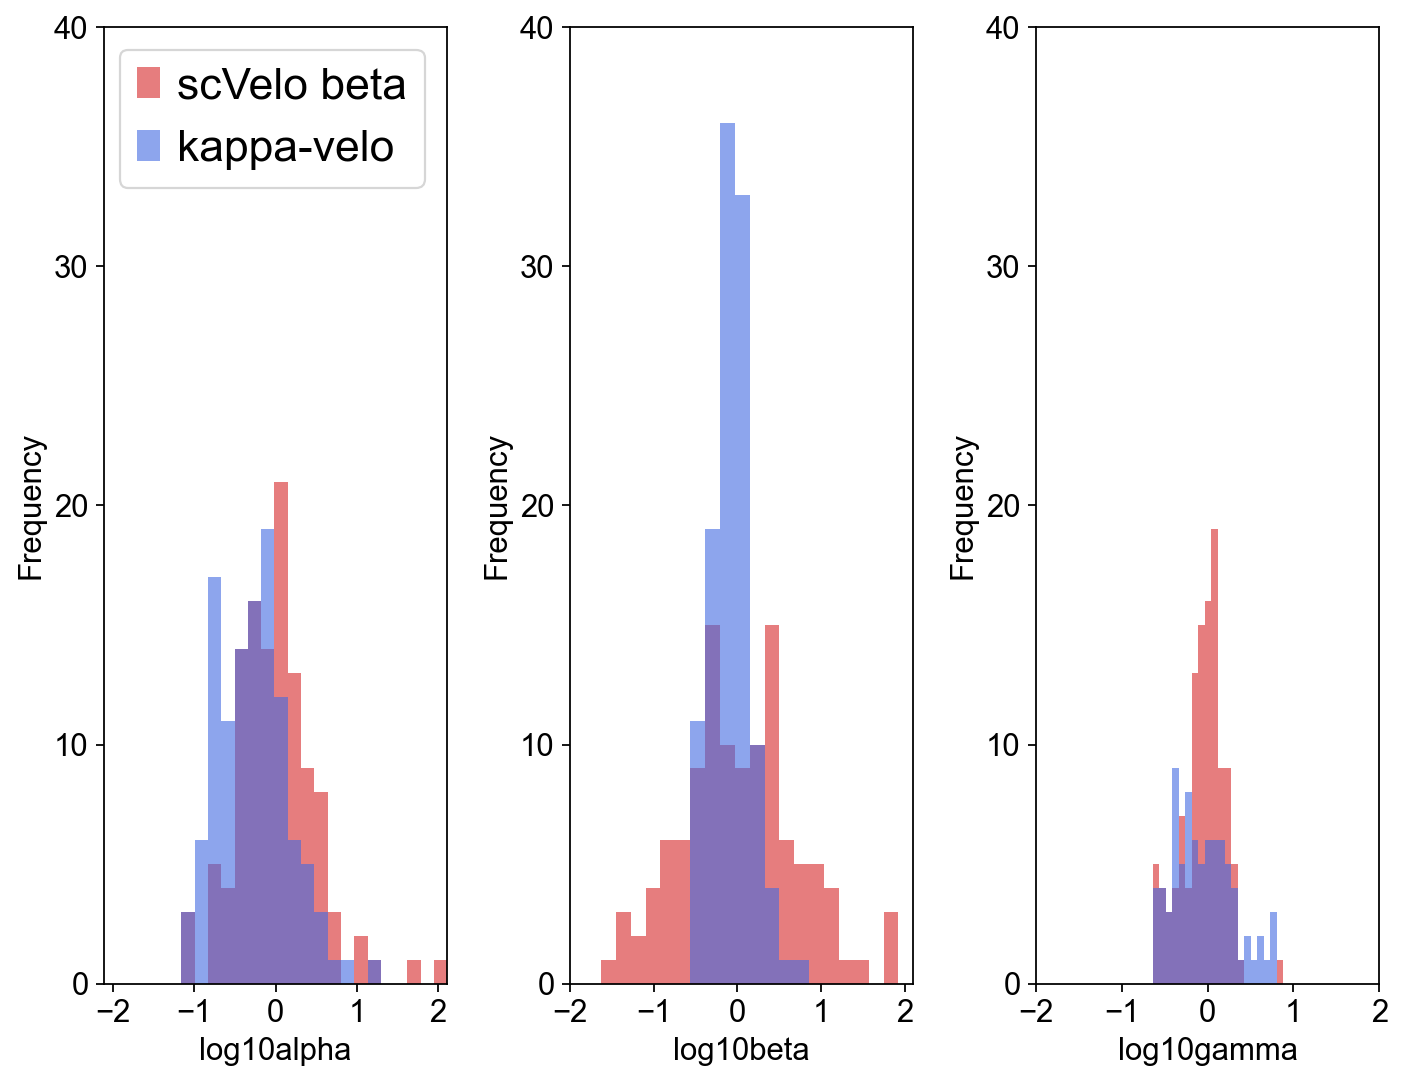

In [63]:
### plot the recovered parameters for original protocol (scVelo) and kappa-velo
fig, axs = plt.subplots(1, 3, figsize=(9,7), frameon=False, sharey=False)

_, bins, _ = axs[0].hist(np.log10(adata.var["fit_alpha"]/np.median(adata.var["fit_alpha"])), bins=20, alpha=.6, color="tab:red", label=["scVelo beta"])
axs[0].hist(np.log10(new_alpha/np.mean(new_alpha)), bins=bins, alpha = .6, color="royalblue", label=["kappa-velo"])
l = np.max(np.log10(adata.var["fit_alpha"]/np.median(adata.var["fit_alpha"])))
axs[0].set_xlim((-l, l))

_, bins, _ = axs[1].hist(np.log10(adata.var["fit_beta"]/np.median(adata.var["fit_beta"])), bins=20, alpha=.6, color="tab:red")
axs[1].hist(np.log10(new_beta/np.mean(new_beta)), bins=bins, alpha = .6, color="royalblue")
l = np.max(np.log10(adata.var["fit_alpha"]/np.median(adata.var["fit_alpha"])))
axs[0].set_xlim((-l, l))

_, bins, _ = axs[2].hist(np.log10(adata.var["fit_gamma"]/np.median(adata.var["fit_gamma"])), bins=20, alpha=.6, color="tab:red")
axs[2].hist(np.log10(new_gamma/np.mean(new_gamma)), bins=bins, alpha = .6, color="royalblue")
l = np.max(np.log10(adata.var["fit_gamma"]/np.median(adata.var["fit_gamma"])))
axs[2].set_xlim((-l, l))

pars = ["alpha", "beta", "gamma"]
for i in range(3):
    axs[i].grid(False)
    axs[i].set_xticks([-2, -1, 0, 1, 2])
    axs[i].set_yticks([0, 10, 20, 30, 40])
    axs[i].set_ylabel("Frequency")
    axs[i].set_xlabel("log10" +pars[i])
    
axs[0].legend(fontsize=20)

plt.tight_layout()

# save figure
save_path = "../figures/FigS5_recovered_parameters_pancreas.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

After scaling the parameters, we want to have a look at a few "fast" and "slow" genes. We consider genes fast when they have high splicing rates and slow when they have low splicing rates.

In [23]:
### set arguments for plotting
kwargs = {"s":50, "ncols":5, "fontsize":20, "frameon":False, 
          "legend_fontsize":0, "legend_loc_lines":"none", "color":"clusters"}

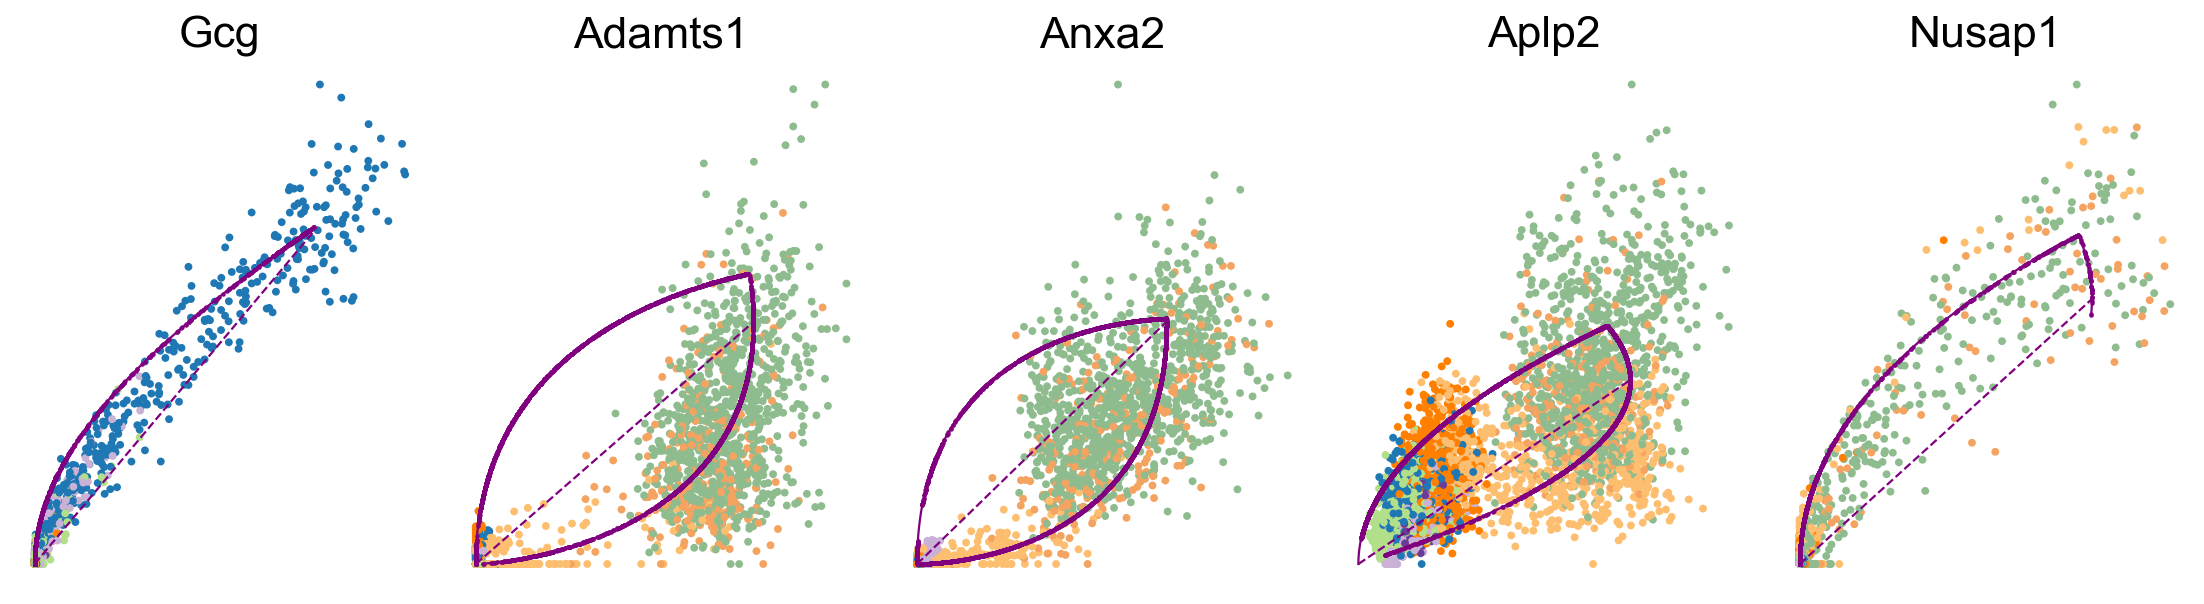

In [31]:
### plot fastest genes
fig, axs = plt.subplots(1, 5, figsize=(14,4), frameon=False)

idx = np.argsort(-adata.var["fit_beta"]*fitted_kappas)[:5].tolist()

for i in range(5):
    scv.pl.scatter(adata, adata.var_names[idx][i], ax=axs[i], show=False, **kwargs)
    axs[i].grid(False)
plt.tight_layout()

# save figure
save_path = "../figures/Fig4B_pancreas_fast_genes.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

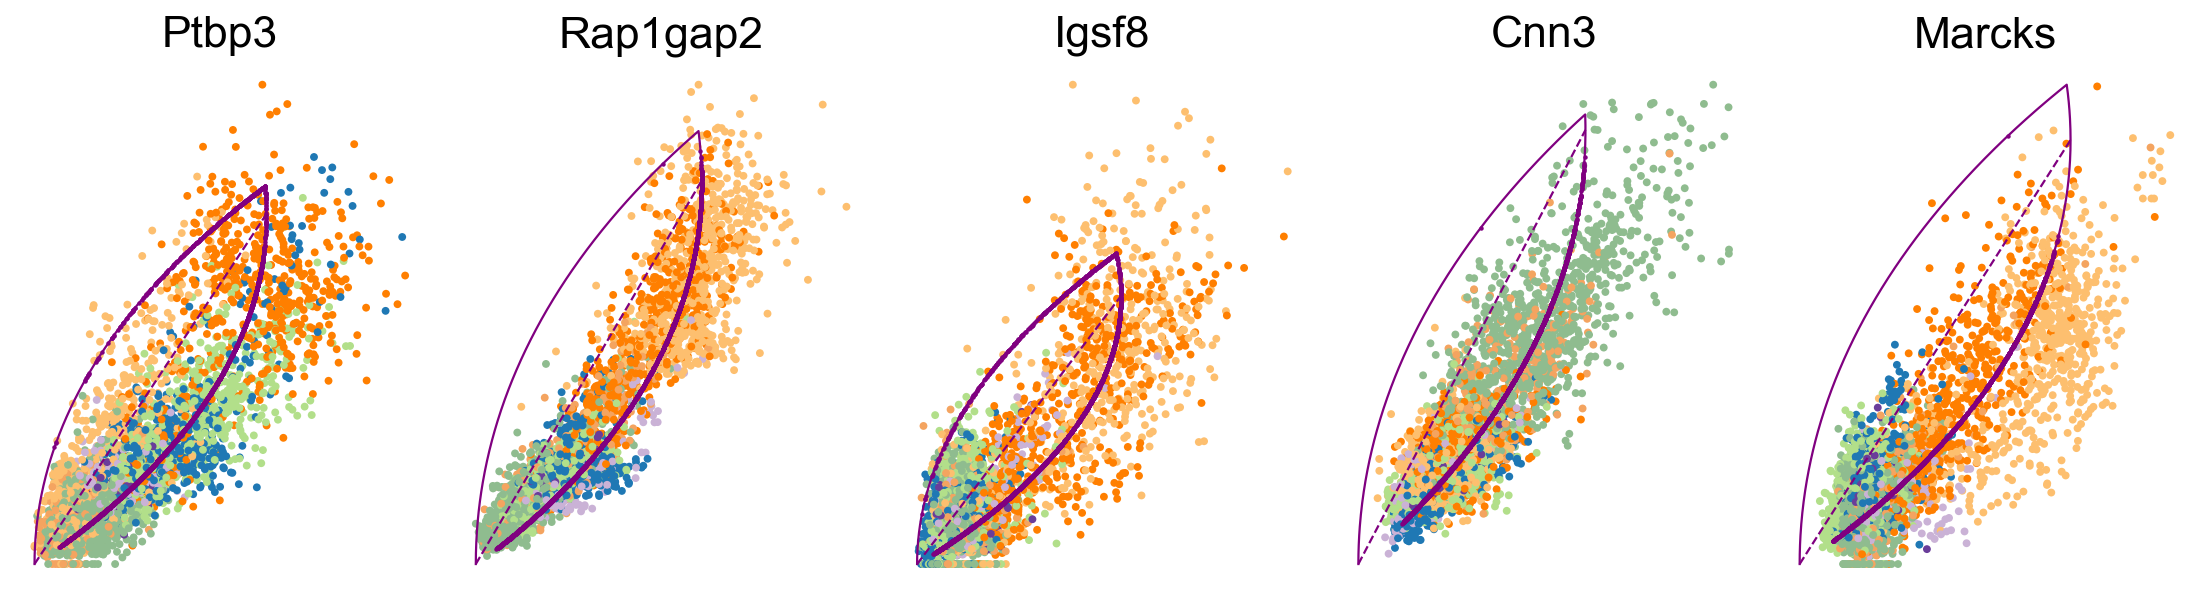

In [37]:
### plot slowest genes
fig, axs = plt.subplots(1, 5, figsize=(14,4), frameon=False)

idx=np.argsort(adata.var["fit_beta"]*fitted_kappas)[:10][[4,5,6,7,9]].tolist()

for i in range(5):
    scv.pl.scatter(adata, adata.var_names[idx][i], ax=axs[i], show=False, **kwargs)
    axs[i].grid(False)
plt.tight_layout()

# save figure
save_path = "../figures/Fig4B_pancreas_slow_genes.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()


### Visualisation of the velocities

Here, we will visualise the scaled velocities both on a PCA and UMAP embedding. First, we recover the embedding on the spliced counts only and then we project the velocties onto embedding. Since PCA is a linear embedding this is relativelt straightforward. For non-linear embedddings, this is more complex. For the theory behind the projection of new points onto existing non-linear embeddings we refer you to the Methods section in our manuscript.

### (I) PCA

First, we calculate the PCA embedding on the imputed spliced counts.

In [102]:
### scale data (imputed spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["Ms"])

In [103]:
### run PCA
n_pcs = 10
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

In [104]:
### check for duplicates in the PCA space
duplicate = get_duplicate_row(pca_pts)
print(duplicate)
unique = np.ones(pca_pts.shape[0]).astype(bool)
unique[duplicate] = 0

[675]


In [105]:
### create copy of adata for scaled data
scaled_data = adata.copy()

### adapt parameters in scaled data
scaled_data.var["fit_beta"] = new_beta
scaled_data.var["fit_alpha"] = new_alpha
scaled_data.var["fit_gamma"] = new_gamma

In [106]:
### calculate velocity
get_velocity(scaled_data, use_raw=False)

In [107]:
### scale down velocities 
velocity_down_scale = 400
S_fut = scal.transform(adata.layers["Ms"]+(scaled_data.layers["velocity"]/velocity_down_scale))

In [108]:
### calculate future states (imputed spliced counts + velocities)
pca_fut = pca.transform(S_fut)

In [109]:
### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
c=adata.obs["clusters"].map(color_dict)

In [110]:
### set arguments for plotting
pltkwargs={"figsize":(10, 6), "frameon":False}
light_color = np.array([lighten_color(i, .3) for i in c])
sub = np.arange(0, adata.shape[0], 1)
pca_quiver_kwargs = {"scale": .8, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
                     "linewidth": 0.5, "headwidth": 5, "headaxislength": 4}

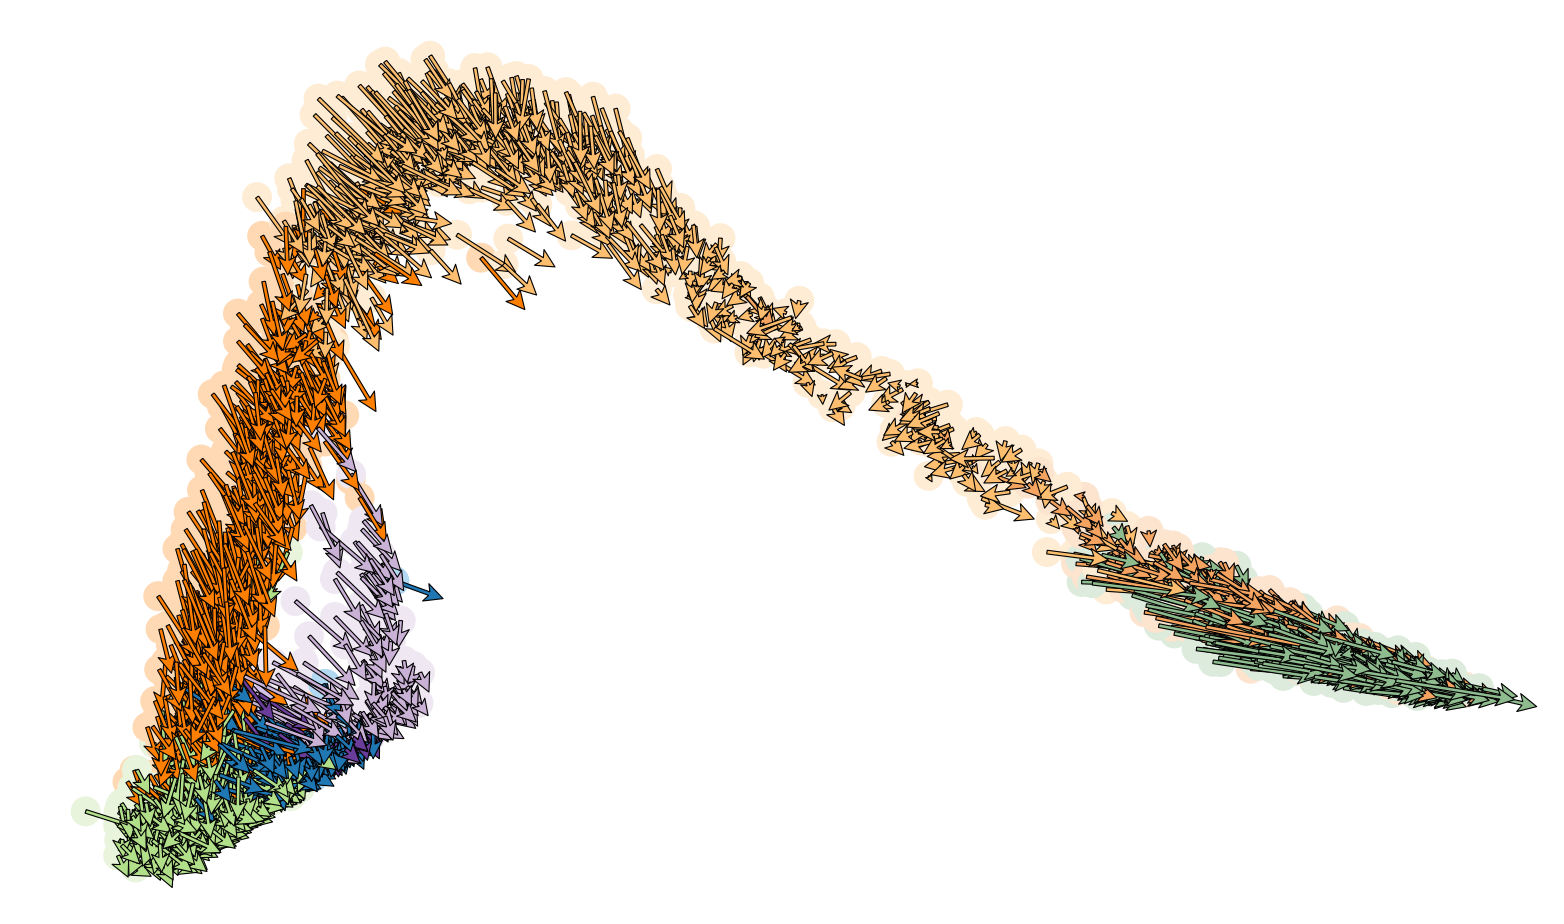

In [111]:
### create PCA plot of pancreas by kappa-velo
fig, ax = plt.subplots(1, 1, **pltkwargs)

ax.scatter(pca_pts[sub,0], pca_pts[sub,1], s=155, color=light_color)
ax.axis("off")
ax.quiver(pca_pts[:,0], pca_pts[:,1], pca_fut[:,0]-pca_pts[:,0], pca_fut[:,1]-pca_pts[:,1],
         color=c, **pca_quiver_kwargs)

fig.tight_layout()
plt.show()

### (II) UMAP

Here, we project the calculated (scaled) velocities onto an UMAP embedding. 

In [112]:
### recalculate UMAP on current subset of genes (spliced counts only)
reducer = umap.UMAP(random_state=0, n_neighbors=110, min_dist=.6, n_components=2, metric="euclidean")
adata.obsm['X_umap'] = reducer.fit_transform(pca_pts)

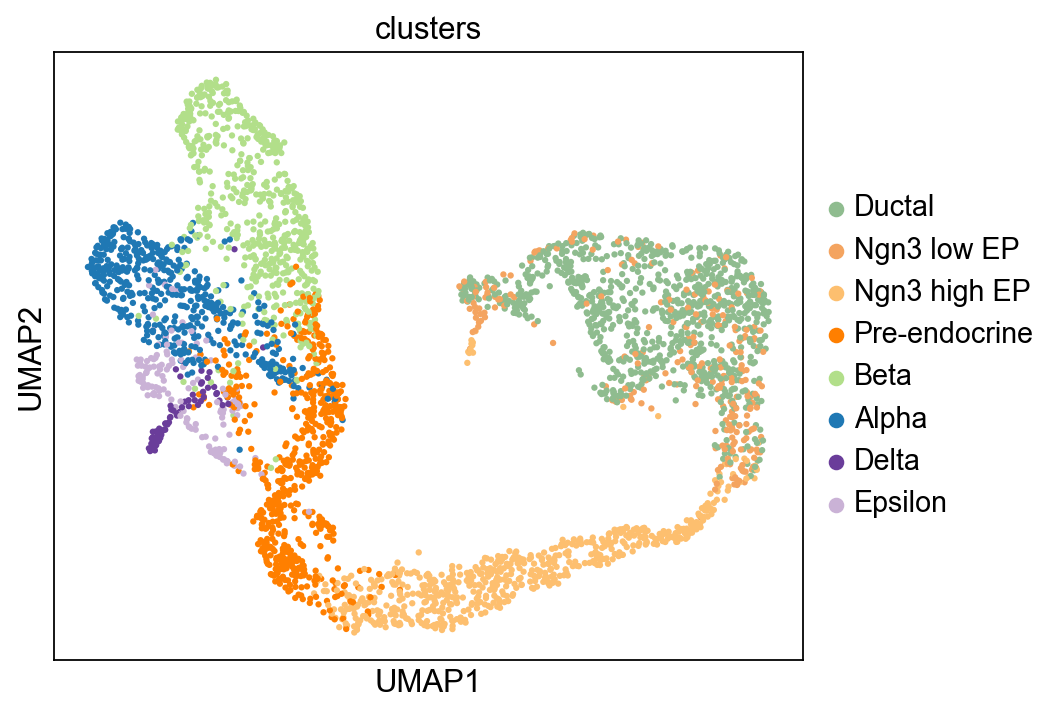

In [113]:
### plot UMAP (just spliced counts)
fig, axs = plt.subplots(1, 1, figsize=(6, 5), frameon=False)
sc.pl.umap(adata, color='clusters', ax=axs)
plt.show()

Here, we calculate the projection of the velocities onto the UMAP embedding.

In [114]:
### calculate velocity projections
k = 300

# get W matrix
d2 = pairwise_distances(pca_pts[unique], metric="euclidean")
NN = cKDTree(pca_pts[unique]).query(x=pca_pts[unique], k=k, n_jobs=1)[1] # we restrict to top 300 NN for faster comp
P_proj = tsne_d2p_NN(d2, NN, row_norm=True)
data = adata.obsm['X_umap'][unique]
W = nystrom(P_proj, data)


# get transp to future states
d2_ = pairwise_distances(pca_fut[unique], pca_pts[unique], metric="euclidean")
NN = cKDTree(pca_pts[unique]).query(x=pca_fut[unique], k=k, n_jobs=1)[1]
P_2 = tsne_d2p_NN(d2_, NN)

v_projected = (np.dot(P_2, W)-data)
v_projected /= np.std(v_projected.flatten()) # s.t. they are easier to compare before and after scaling

# smoothed arrows
NN = cKDTree(adata.layers["Ms"][unique]).query(x=adata.layers["Ms"][unique], k=50, n_jobs=1)[1]
v_projected_mean = np.nanmean(np.array(v_projected)[NN], axis=1)

In [115]:
### set arguments for plotting
umap_pltkwargs={"figsize":(8, 7), "frameon":False}
umap_quiver_kwargs = {"scale": 2,"angles": "xy","scale_units": "xy","edgecolors": "k",
                      "linewidth": 0.2,"width": .002,"headwidth": 4,"headaxislength": 4}
sub = np.ones(np.sum(unique)).astype(bool)
sub[np.arange(0, adata.shape[0], 4)] = False

Here, we plot the result of the complete $\kappa$-velo workflow (processing, velocity calculation and visualisation) on the pancreas endocrinogenesis dataset.

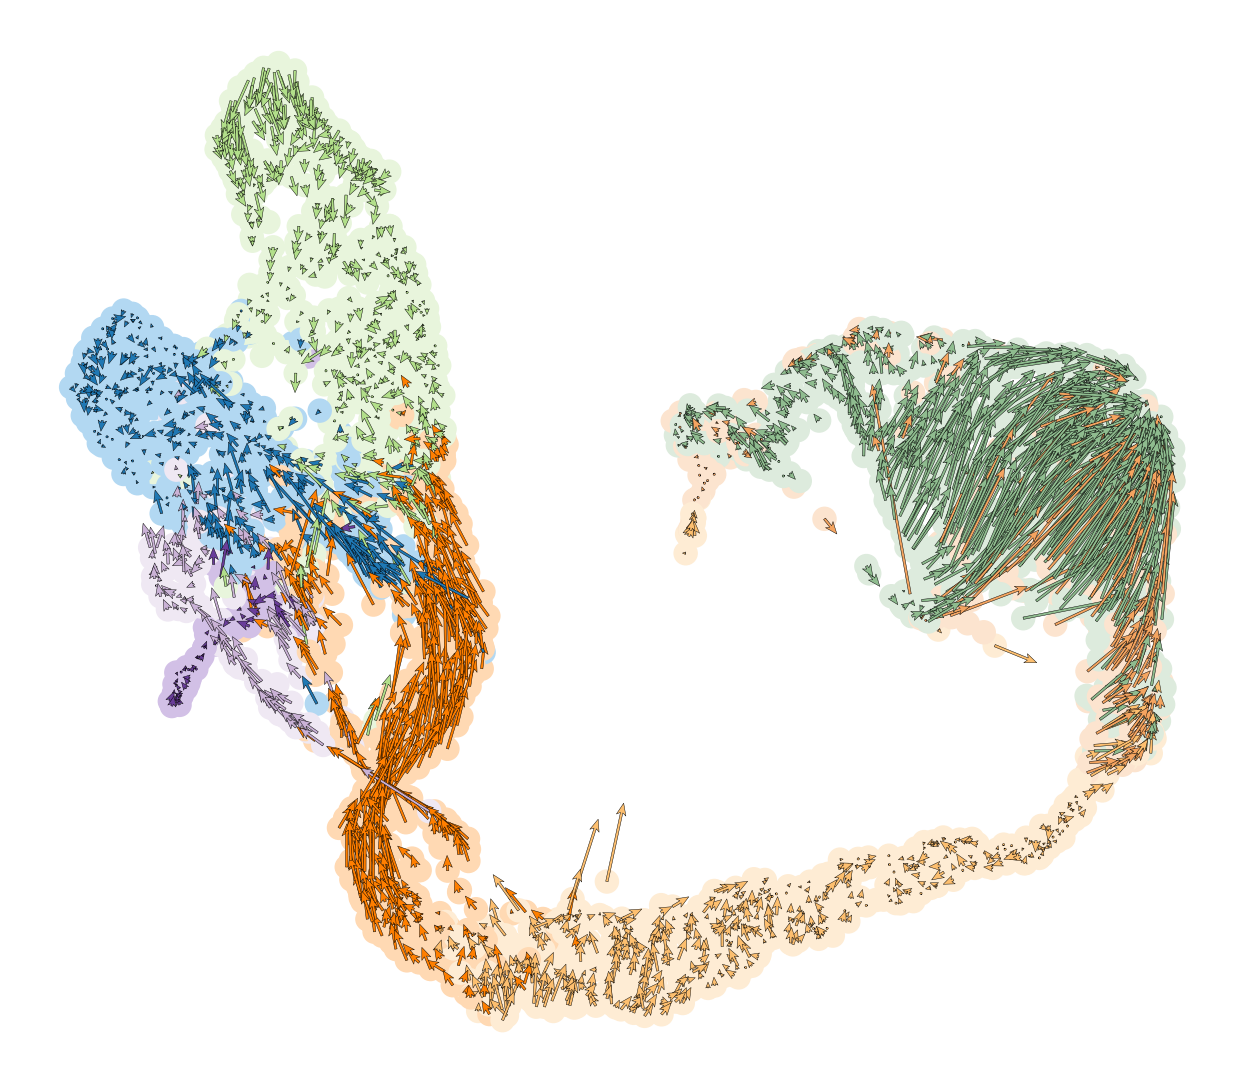

In [116]:
### create UMAP plot of pancreas by kappa-velo
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)
ax.scatter(data[:,0], data[:,1], s=100, c=light_color[unique])
ax.axis("off")
ax.quiver(data[sub,0], data[sub,1], v_projected[sub,0], v_projected[sub,1], 
          color=c[unique][sub], **umap_quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/Fig4C_UMAP_pancreas_kappa_velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

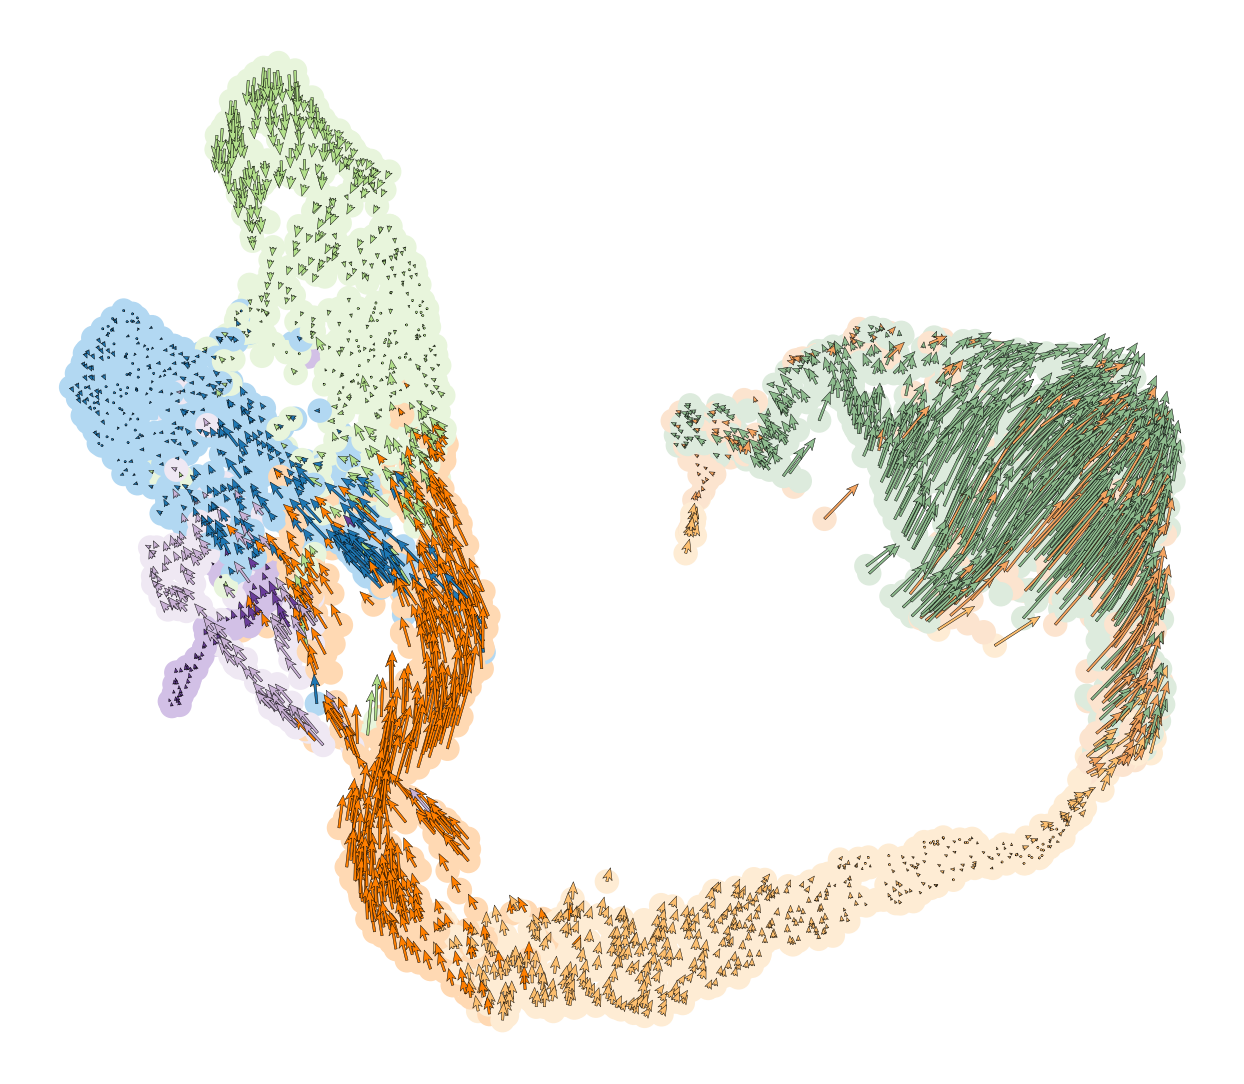

In [117]:
### create smoothed UMAP plot of pancreas by kappa-velo
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)
ax.scatter(data[:,0], data[:,1], s=100, c=light_color[unique])
ax.axis("off")
ax.quiver(data[sub,0], data[sub,1], v_projected_mean[sub,0], v_projected_mean[sub,1],
         color=c[unique][sub], **umap_quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/FigS6A_UMAP_pancreas_kappa_velo_smoothed.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

To calculate the running time of the complete time of the $\kappa$-velo approach on the pancreas endocrinogenesis dataset, we started a timer all the way at the beginning. Here we stop the time and calculate how much time has passed.

In [118]:
### aaaand cut!
end_time = time.time()

def format_time(t):
  return f"{int(t/3600)}H {int((t/60)%60) if t/3600>0 else int(t/60)}M {int(t%60)}S"

print(format_time(end_time-begin_time))

1H 35M 2S


### Compare to scVelo

In [119]:
### get velocities
scv.tl.velocity(adata, mode='dynamical')

### (I) PCA

Here, we visualise the velocities as calculated by scVelo (non-scaled) onto the PCA embedding.

In [120]:
### get future points(spliced counts + velocities) in PCA space
velocity_down_scale = 1
S_fut = scal.transform(adata.layers["Ms"]+(adata.layers["velocity"]/velocity_down_scale))
pca_fut = pca.transform(S_fut)

In [121]:
### set arguments for plotting
sub = np.arange(0, adata.shape[0], 1)
pltkwargs={"figsize":(10, 6), "frameon":False}

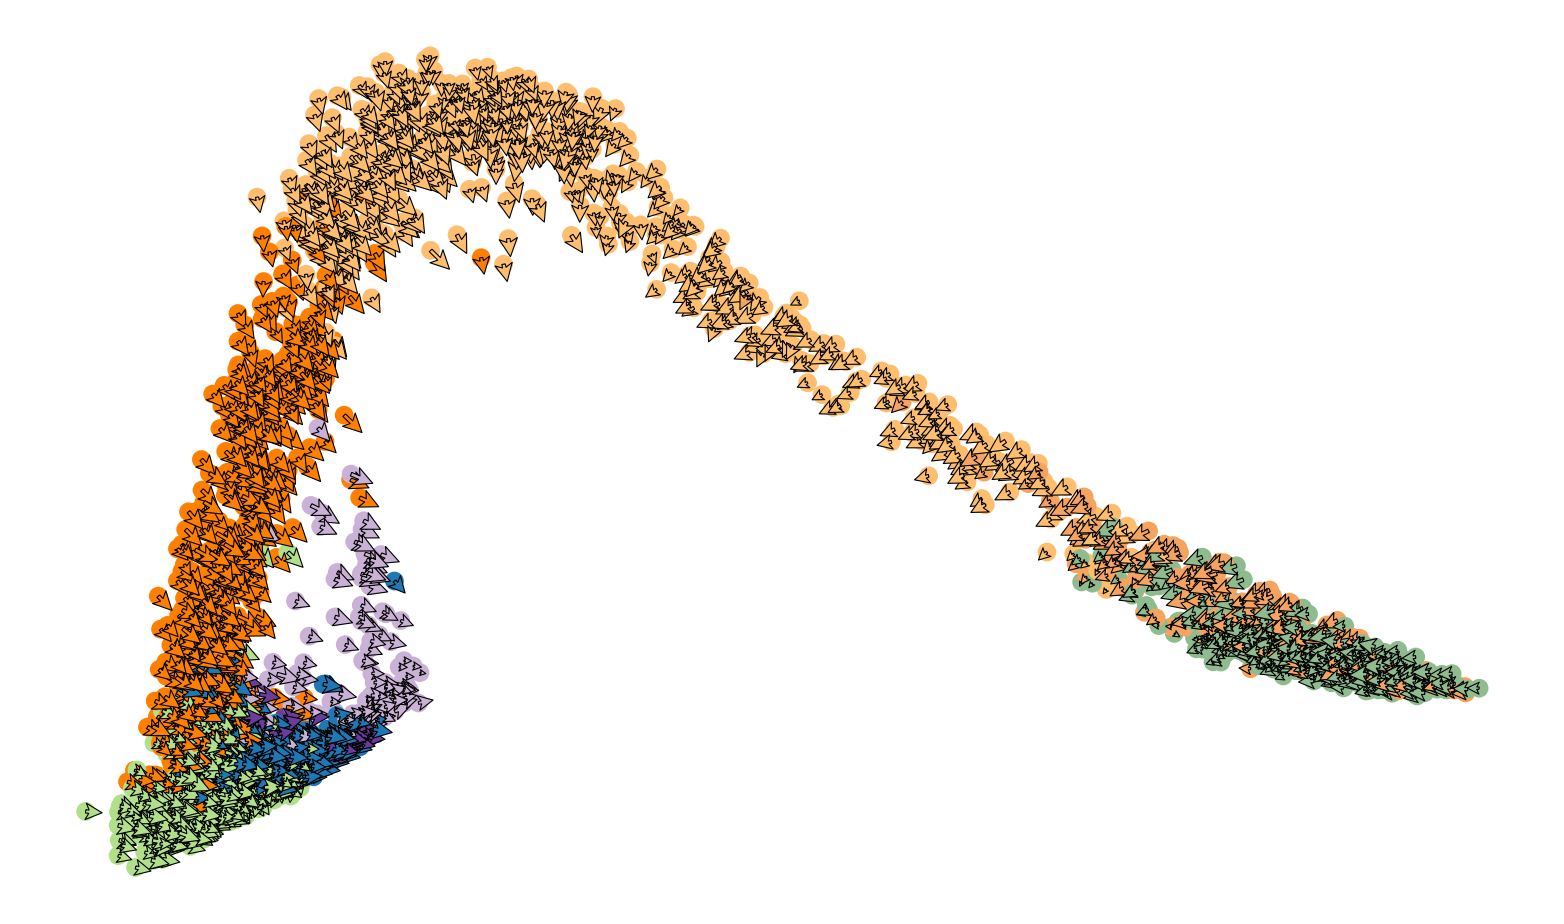

In [122]:
### create PCA plot of pancreas by scVelo 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(pca_pts[sub,0], pca_pts[sub,1], s=55, color=c)
ax.quiver(pca_pts[:,0], pca_pts[:,1], pca_fut[:,0]-pca_pts[:,0], pca_fut[:,1]-pca_pts[:,1],color=c, **pca_quiver_kwargs)
ax.axis("off")
fig.tight_layout()
plt.show()

### (II) UMAP

In [124]:
### get transportion to future states
d2_ = pairwise_distances(pca_fut[unique], pca_pts[unique], metric="euclidean")
NN = cKDTree(pca_pts[unique]).query(x=pca_fut[unique], k=k, n_jobs=1)[1]

P_2 = tsne_d2p_NN(d2_, NN)

v_projected = (np.dot(P_2, W)-data)
v_projected /= np.std(v_projected.flatten()) # s.t. they are easier to compare before and after scaling

NN = cKDTree(adata.layers["Ms"][unique]).query(x=adata.layers["Ms"][unique], k=50, n_jobs=1)[1]
v_projected_mean = np.nanmean(np.array(v_projected)[NN], axis=1)

In [125]:
### set arguments for plotting
sub = np.ones(adata[unique].shape[0]).astype(bool)
sub[np.arange(0, adata[unique].shape[0], 4)] = False

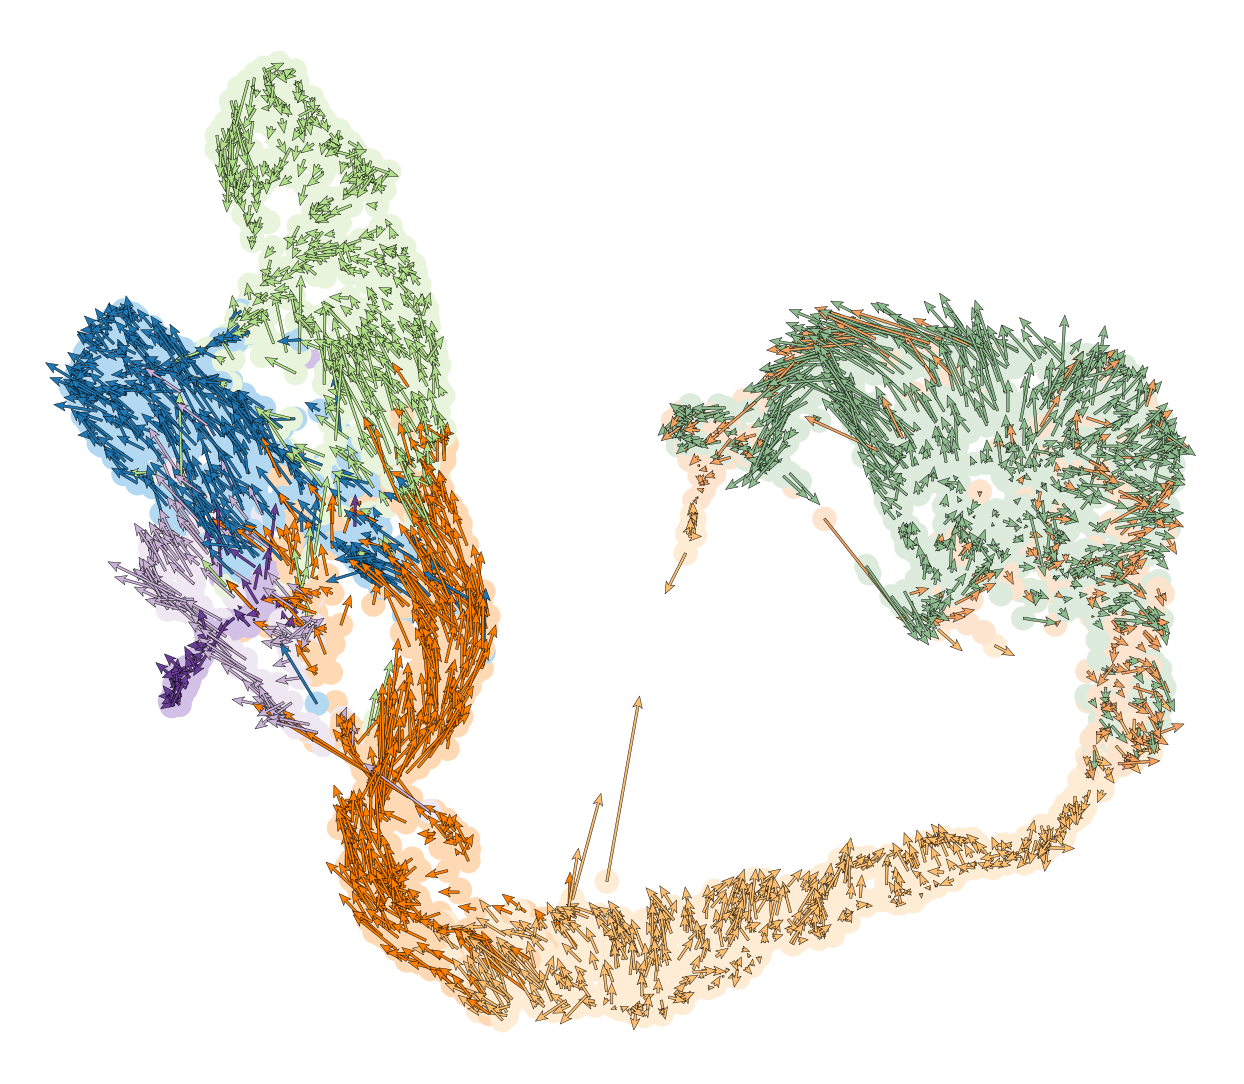

In [126]:
### create UMAP plot of pancreas with velocities calculated by scVelo (non-scaled)
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)
ax.scatter(data[:,0], data[:,1], s=100, c=light_color[unique])
ax.axis("off")
ax.quiver(data[sub,0], data[sub,1], v_projected[sub,0], v_projected[sub,1],
          color=c[unique][sub], **umap_quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/Fig4D_UMAP_pancreas_scVelo_kappa-velo-projection.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

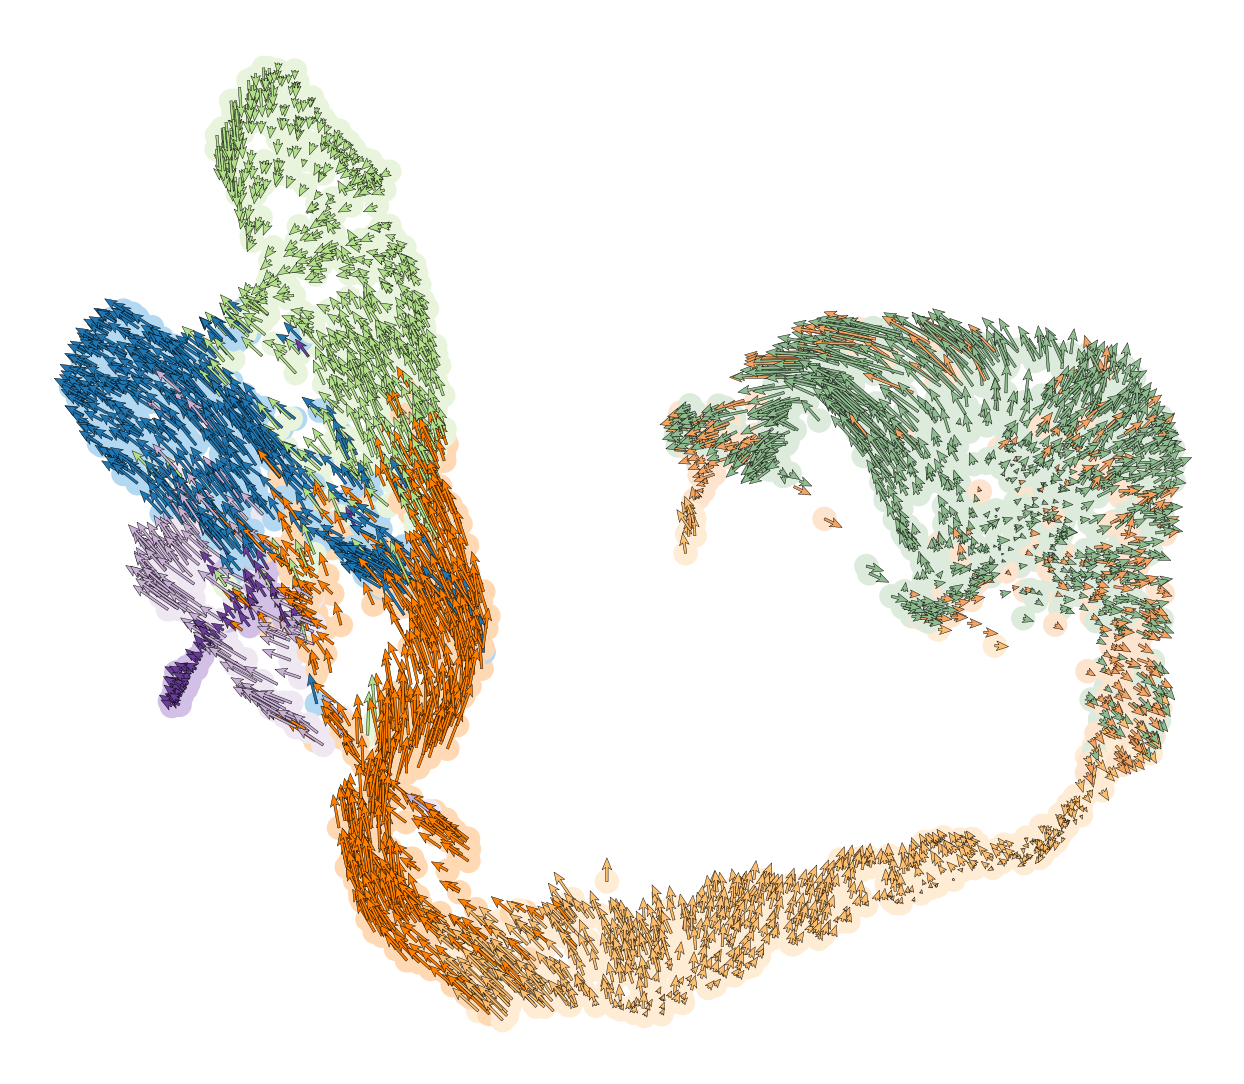

In [127]:
### create UMAP plot of pancreas with smoothed velocities calculated by scVelo (non-scaled)
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)
ax.scatter(data[sub,0], data[sub,1], s=100, c=light_color[unique][sub])
ax.axis("off")
ax.quiver(data[:,0], data[:,1], v_projected_mean[:,0], v_projected_mean[:,1],
          color=c[unique], **umap_quiver_kwargs)
fig.tight_layout()

# save figure
save_path = "../figures/FigS6B_UMAP_pancreas_scVelo_kappa-velo-projection_smoothed.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

Lastly, we want to compare the $\kappa$-velo velocity calculation and visualisation to the scVelo velocity calculation and visualisation (the figures above only compared the velocity calculation, but used the $\kappa$-velo visualisation in both cases).

In [128]:
### calculate scVelos visualisation
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis='umap', scale=.1)
v_scvelo = adata.obsm["velocity_umap"]
v_scvelo /= np.std(v_scvelo.flatten())

ValueError: Argument U has a size 3696 which does not match 3695, the number of arrow positions

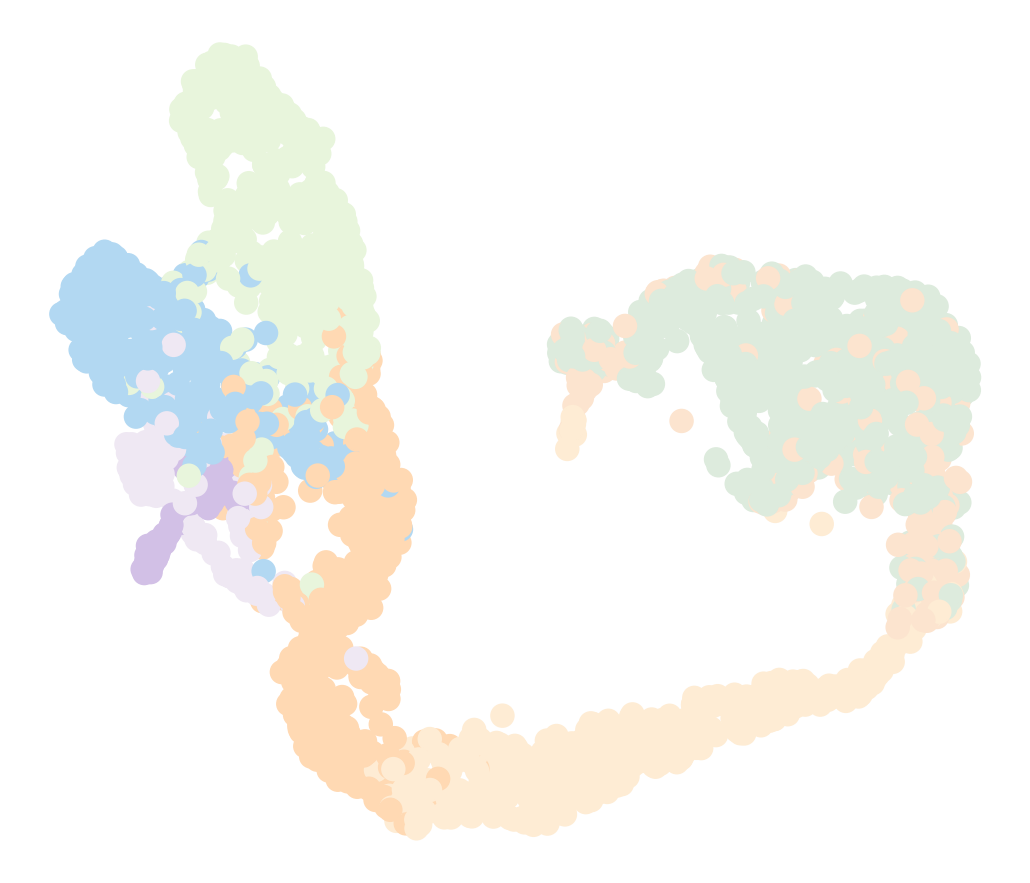

In [129]:
### create UMAP plot of pancreas - scVelo velocities (non-scaled) and visualisation
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)
ax.scatter(data[sub,0], data[sub,1], s=100, c=light_color[unique][sub])
ax.axis("off")
ax.quiver(data[:,0], data[:,1], v_scvelo[:,0], v_scvelo[:,1],
         color=c[unique],
          **umap_quiver_kwargs
 
         )
fig.tight_layout()

# save figure
save_path = "../figures/Fig4E_UMAP_pancreas_scVelo_scVelo-projection_smoothed.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()